## Evaluation of test set predictive results after basic resampling techniques on training set 

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('paper')

In [2]:
def select(query):
    
    conn = sqlite3.connect('./data/lending-club-loan-data/database2.sqlite')
    cursor = conn.cursor()
    temp_df = pd.DataFrame(cursor.execute(query).fetchall())
    temp_df.columns = list(map(lambda x: x[0], cursor.description))
    conn.close()
    
    return temp_df.copy()

In [3]:
features_train = select('SELECT * FROM FEATURES_TRAIN')
targets_train = select('SELECT * FROM TARGETS_TRAIN')
features_test = select('SELECT * FROM FEATURES_TEST')
targets_test = select('SELECT * FROM TARGETS_TEST')

In [4]:
# training data has approx 1:5 ratio of minority to majority class examples

ratio = -1*((targets_train.loan_status-1).sum())/targets_train.loan_status.sum()
ratio

0.2153942473241268

### Training Set Manipulation approach 1: Undersampling of the majority class


In [5]:
# ratio_dict1: undersample the majority class to create a 1:1 ratio of minority to majority class examples
# ratio_dict2: undersample the majority class to create a 2:1 ratio of minority to majority class examples

from imblearn.under_sampling import RandomUnderSampler

ratio_dict1 = {0:len(features_train[~targets_train.astype(bool).loan_status]),\
               1:len(features_train[~targets_train.astype(bool).loan_status])}
ratio_dict2 = {0:len(features_train[~targets_train.astype(bool).loan_status]),\
                1:round((.5*len(features_train[~targets_train.astype(bool).loan_status])))}

features_res1, targets_res1 = RandomUnderSampler(ratio=ratio_dict1,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)
    
features_res2, targets_res2 = RandomUnderSampler(ratio=ratio_dict2,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 1:1 minority to majority class undersampling

In [7]:
# accuracy considerably drops -- this same baseline model in pt1 had 82% accuracy on the test set

lr = LogisticRegression()
lr.fit(features_res1,targets_res1)
print(accuracy_score(lr.predict(features_test),targets_test))

0.641775963863


In [8]:
# precision drops from 50% to 28%, but this model in pt1 only made 4 negative class predictions. there remains room for
# improvement in precision, but model has become much more sensitive to outputting the minority class
# recall is GREATLY improved -- this model in pt1 has close to 0% recall on the test set

print('TRAIN LR')
print(classification_report(targets_res1,lr.predict(features_res1)))
print('TEST LR')
print(classification_report(targets_test,lr.predict(features_test)))

TRAIN LR
             precision    recall  f1-score   support

          0       0.65      0.64      0.64     35780
          1       0.64      0.65      0.65     35780

avg / total       0.64      0.64      0.64     71560

TEST LR
             precision    recall  f1-score   support

          0       0.28      0.63      0.38      8929
          1       0.89      0.64      0.75     41545

avg / total       0.78      0.64      0.68     50474



In [9]:
# increase the number of trees in RF from default 10 to 64

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

GNB = GaussianNB().fit(features_res1,targets_res1)
KNN = KNeighborsClassifier().fit(features_res1,targets_res1)
RF = RandomForestClassifier(n_estimators=64).fit(features_res1,targets_res1)

# metrics are for the test set only, for: Gaussian NB, kNN, and Random Forest classifiers

# unlike the case without undersampling, these three models offer little performance improvement in any of the metrics
# over logistic regression. undersampling seems to greatly improve logistic regression's performance, bringing it up to par
# with other algorithms (a bit better, even). still, the other algorithms have notable performance gains from undersampling

print('GNB')
print(classification_report(targets_test,GNB.predict(features_test)))
print('kNN')
print(classification_report(targets_test,KNN.predict(features_test)))
print('RF')
print(classification_report(targets_test,RF.predict(features_test)))

GNB
             precision    recall  f1-score   support

          0       0.28      0.57      0.37      8929
          1       0.88      0.68      0.77     41545

avg / total       0.77      0.66      0.70     50474

kNN
             precision    recall  f1-score   support

          0       0.20      0.54      0.29      8929
          1       0.85      0.54      0.66     41545

avg / total       0.73      0.54      0.60     50474

RF
             precision    recall  f1-score   support

          0       0.27      0.66      0.38      8929
          1       0.89      0.61      0.72     41545

avg / total       0.78      0.62      0.66     50474



### 2:1 minority to majority class undersampling

In [10]:
# accuracy is concerningly low..perhaps we are sacrificing too much in the recall of positive examples

lr2 = LogisticRegression()
lr2.fit(features_res2,targets_res2)
print(accuracy_score(lr2.predict(features_test),targets_test))

0.278341324246


In [11]:
# recall on the negative class is extremely good, but we have sacrificed too much predictability on the majority class
# (the negative class precision is quite low on the test set..the model is now insensitive to positive predictions)

# there seems to be a balance that we can achieve between metric performance on positive/negative examples
# by changing the ratio of minority to majority class examples, but ideally we want to perform well on both

# rather than simply adjusting the ratio of class examples, we move onto other resampling techniques and applying
# different algorithms w/ hyperparameter optimization to aim for better performance on both metrics on both classes

print('TRAIN'+classification_report(targets_res2,lr2.predict(features_res2)))
print('TEST'+classification_report(targets_test,lr2.predict(features_test)))

print('test set negative class predictions: '+str((lr2.predict(features_test)-1).sum()*-1))
print('test set positive class predictions: '+str((lr2.predict(features_test)).sum()))

TRAIN             precision    recall  f1-score   support

          0       0.69      0.96      0.80     35780
          1       0.62      0.13      0.22     17890

avg / total       0.67      0.68      0.61     53670

TEST             precision    recall  f1-score   support

          0       0.19      0.96      0.32      8929
          1       0.94      0.13      0.23     41545

avg / total       0.81      0.28      0.25     50474

test set negative class predictions: 44622
test set positive class predictions: 5852


In [12]:
# note - use this formatting for cleaner output

GNB2 = GaussianNB().fit(features_res2,targets_res2)
KNN2 = KNeighborsClassifier().fit(features_res2,targets_res2)
RF2 = RandomForestClassifier(n_estimators=64).fit(features_res2,targets_res2)

print('GNB')
print(classification_report(targets_test,GNB2.predict(features_test)))
print('kNN')
print(classification_report(targets_test,KNN2.predict(features_test)))
print('RF')
print(classification_report(targets_test,RF2.predict(features_test)))

GNB
             precision    recall  f1-score   support

          0       0.24      0.75      0.37      8929
          1       0.90      0.50      0.64     41545

avg / total       0.79      0.54      0.59     50474

kNN
             precision    recall  f1-score   support

          0       0.19      0.79      0.30      8929
          1       0.86      0.27      0.41     41545

avg / total       0.74      0.36      0.39     50474

RF
             precision    recall  f1-score   support

          0       0.22      0.89      0.35      8929
          1       0.93      0.30      0.46     41545

avg / total       0.80      0.41      0.44     50474



In [13]:
# regardless of undersampling ratio, precision is fairly poor across the board

In [123]:
# summarize the process done above, over several resampled ratios of minority : majority examples

multiples = [4,3.5,3,2.5,2,1.5,1,0.5]
ratios = []
for multiple in multiples:
    ratios.append(1/multiple)

pos_precisions = []
pos_recalls = []
pos_f1s = []
neg_precisions = []
neg_recalls = []
neg_f1s = []


lr = LogisticRegression()

for multiple in multiples:
    
    ratio_dict = {0:len(features_train[~targets_train.astype(bool).loan_status]),\
               1:int(multiple*len(features_train[~targets_train.astype(bool).loan_status]))}
    
    features_res, targets_res = RandomUnderSampler(ratio=ratio_dict,random_state=2)\
        .fit_sample(features_train,targets_train.loan_status)
    
    predictions = lr.fit(features_res,targets_res).predict(features_test)
    tn, fp, fn, tp = confusion_matrix(targets_test,predictions).ravel()
    
    pos_precisions.append(tp/(tp+fp))
    pos_recalls.append(tp/(tp+fn))
    neg_precisions.append(tn/(tn+fn))
    neg_recalls.append(tn/(tn+fp))
    pos_f1s.append(2*(tp/(tp+fp))*tp/(tp+fn)/((tp/(tp+fp))+(tp/(tp+fn))))
    neg_f1s.append(2*(tn/(tn+fn))*tn/(tn+fp)/((tn/(tn+fn))+(tn/(tn+fp))))

Text(0.5,1.1,'Logistic Regression Performance')

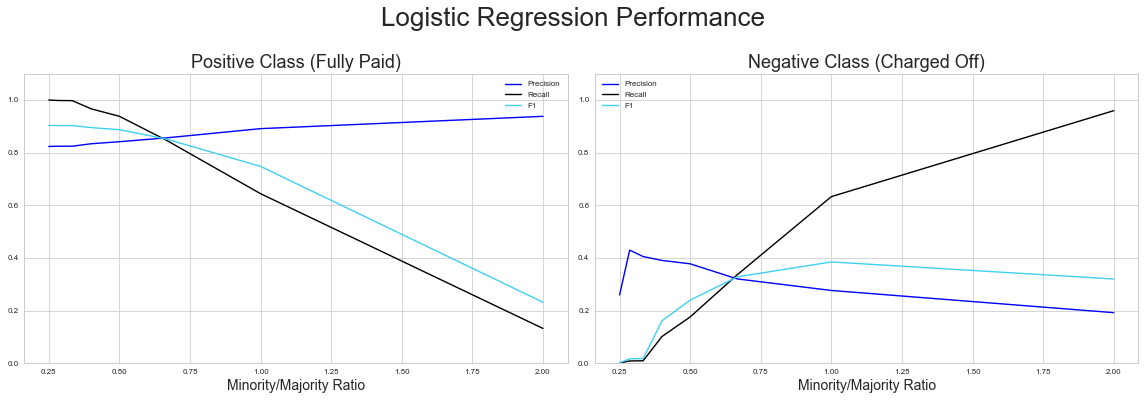

In [158]:
fig, ((ax1,ax2)) = plt.subplots(1,2,figsize=(16,5))

ax1.plot(ratios,pos_precisions,'b')
ax1.plot(ratios,pos_recalls,'k')
ax1.plot(ratios,pos_f1s,'#41d0f4')
ax1.legend(['Precision','Recall','F1'])
ax1.set_title('Positive Class (Fully Paid)',fontsize=18)
ax1.set_xlabel('Minority/Majority Ratio',fontsize=14)
ax1.set_ylim([0,1.1])

ax2.plot(ratios,neg_precisions,'b')
ax2.plot(ratios,neg_recalls,'k')
ax2.plot(ratios,neg_f1s,'#41d0f4')
ax2.legend(['Precision','Recall','F1'])
ax2.set_title('Negative Class (Charged Off)',fontsize=18)
ax2.set_xlabel('Minority/Majority Ratio',fontsize=14)
ax2.set_ylim([0,1.1])

plt.tight_layout()
plt.suptitle('Logistic Regression Performance',fontsize=26,x=0.5,y=1.1)

---

#### we do not explore simple oversampling of the minority class -- known tendency to cause models to overfit

### Training Set Manipulation Approach 2: SMOTE (Synthetic Minority Oversampling Technique)
generates artifical data points of the minority class at random points in between existing minority class examples (in the features space, using kNN), thus "filling" the potential decision region of the minority class (increasing the count) without causing an overfit on already-existing minority class examples

In [14]:
from imblearn.over_sampling import SMOTE

In [15]:
# Ratio1 - 5:8 ratio (approx.), with minority class 3x its original size
# Ratio2 - 1:1 ratio, with minority class equal to majority class original size
# Ratio3 - 3:2 ratio, with minority class 1.5x time majority class original size

SMOTERatio1 = {0:round(3*len(features_train[~targets_train.astype(bool).loan_status])),\
               1:len(features_train[targets_train.astype(bool).loan_status])}

SMOTERatio2 = {0:len(features_train[targets_train.astype(bool).loan_status]),\
                1:len(features_train[targets_train.astype(bool).loan_status])}

SMOTERatio3 = {0:round(1.5*len(features_train[targets_train.astype(bool).loan_status])),\
                1:len(features_train[targets_train.astype(bool).loan_status])}

features_SMOTE1, targets_SMOTE1 = SMOTE(ratio=SMOTERatio1,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)
    
features_SMOTE2, targets_SMOTE2 = SMOTE(ratio=SMOTERatio2,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)
    
features_SMOTE3, targets_SMOTE3 = SMOTE(ratio=SMOTERatio3,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)

C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (249171) in class 0 will be larger than the number of samples in the majority class (class #1 -> 166114)
  n_samples_majority))


In [16]:
lrSMOTE1 = LogisticRegression().fit(features_SMOTE1,targets_SMOTE1)
lrSMOTE2 = LogisticRegression().fit(features_SMOTE2,targets_SMOTE2)
lrSMOTE3 = LogisticRegression().fit(features_SMOTE3,targets_SMOTE3)

In [17]:
# accuracy decreases as we increase the presence of minority classes. again, this is probably because of the 
# large number of positive classes in the test set

print(accuracy_score(lrSMOTE1.predict(features_test),targets_test))
print(accuracy_score(lrSMOTE2.predict(features_test),targets_test))
print(accuracy_score(lrSMOTE3.predict(features_test),targets_test))

0.740836866506
0.638031461743
0.470559099735


In [18]:
# altering the proportion of negative/positive classes in the training set through SMOTE seems to have a very similar
# effect as doing so through undersampling. we sacrifice recall of the positive class for recall of the negative class,
# and we still have poor precision in the negative class. 

print('5:8 LR TEST')
print(classification_report(targets_test,lrSMOTE1.predict(features_test)))
print('1:1 LR TEST')
print(classification_report(targets_test,lrSMOTE2.predict(features_test)))
print('3:2 LR TEST')
print(classification_report(targets_test,lrSMOTE3.predict(features_test)))

5:8 LR TEST
             precision    recall  f1-score   support

          0       0.32      0.41      0.36      8929
          1       0.86      0.81      0.84     41545

avg / total       0.77      0.74      0.75     50474

1:1 LR TEST
             precision    recall  f1-score   support

          0       0.27      0.64      0.38      8929
          1       0.89      0.64      0.74     41545

avg / total       0.78      0.64      0.68     50474

3:2 LR TEST
             precision    recall  f1-score   support

          0       0.23      0.83      0.36      8929
          1       0.92      0.39      0.55     41545

avg / total       0.79      0.47      0.52     50474



In [19]:
GNB_SMOTE1 = GaussianNB().fit(features_SMOTE1,targets_SMOTE1)
KNN_SMOTE1 = KNeighborsClassifier().fit(features_SMOTE1,targets_SMOTE1)
RF_SMOTE1 = RandomForestClassifier(n_estimators=64).fit(features_SMOTE1,targets_SMOTE1)

In [20]:
# as in the case with undersampling, these other algorithms seem to have no great performance jump compared to logistic
# regression. these algorithms seem less sensitive to the proportion of class sizes

print('5:8 GNB TEST')
print(classification_report(targets_test,GNB_SMOTE1.predict(features_test)))
print('5:8 kNN TEST')
print(classification_report(targets_test,KNN_SMOTE1.predict(features_test)))
print('5:8 RF TEST')
print(classification_report(targets_test,RF_SMOTE1.predict(features_test)))

5:8 GNB TEST
             precision    recall  f1-score   support

          0       0.28      0.55      0.37      8929
          1       0.88      0.69      0.77     41545

avg / total       0.77      0.67      0.70     50474

5:8 kNN TEST
             precision    recall  f1-score   support

          0       0.21      0.33      0.25      8929
          1       0.83      0.73      0.78     41545

avg / total       0.72      0.66      0.68     50474

5:8 RF TEST
             precision    recall  f1-score   support

          0       0.41      0.10      0.16      8929
          1       0.83      0.97      0.90     41545

avg / total       0.76      0.82      0.77     50474



In [21]:
GNB_SMOTE2 = GaussianNB().fit(features_SMOTE2,targets_SMOTE2)
KNN_SMOTE2 = KNeighborsClassifier().fit(features_SMOTE2,targets_SMOTE2)
RF_SMOTE2 = RandomForestClassifier(n_estimators=64).fit(features_SMOTE2,targets_SMOTE2)

In [22]:
print('1:1 GNB TEST')
print(classification_report(targets_test,GNB_SMOTE2.predict(features_test)))
print('1:1 kNN TEST')
print(classification_report(targets_test,KNN_SMOTE2.predict(features_test)))
print('1:1 RF TEST')
print(classification_report(targets_test,RF_SMOTE2.predict(features_test)))

1:1 GNB TEST
             precision    recall  f1-score   support

          0       0.25      0.67      0.37      8929
          1       0.89      0.57      0.70     41545

avg / total       0.78      0.59      0.64     50474

1:1 kNN TEST
             precision    recall  f1-score   support

          0       0.20      0.42      0.27      8929
          1       0.84      0.64      0.72     41545

avg / total       0.72      0.60      0.64     50474

1:1 RF TEST
             precision    recall  f1-score   support

          0       0.38      0.11      0.18      8929
          1       0.83      0.96      0.89     41545

avg / total       0.75      0.81      0.77     50474



In [23]:
# there seem to be very clear limits/utility in resampling to improve model performance. we explore one more resampling
# technique before moving onto other approaches to improving predictive quality

### Training Set Manipulation Approach 3: ADASYN (Adaptive Synthetic Sampling)
similar to SMOTE, but generates artifical minority class examples with a weight for generating more minority class data points in the feature space which are "difficult" to learn (noisy, greatly overlapping with majority class)

In [24]:
from imblearn.over_sampling import ADASYN

In [25]:
# Ratio1 - 5:8 ratio (approx.), with minority class 3x its original size
# Ratio2 - 1:1 ratio, with minority class equal to majority class original size
# Ratio3 - 3:2 ratio, with minority class 1.5x time majority class original size

# same ratios as in SMOTE..don't really need to re-instantiate

ADASYNRatio1 = {0:round(3*len(features_train[~targets_train.astype(bool).loan_status])),\
               1:len(features_train[targets_train.astype(bool).loan_status])}

ADASYNRatio2 = {0:len(features_train[targets_train.astype(bool).loan_status]),\
                1:len(features_train[targets_train.astype(bool).loan_status])}

ADASYNRatio3 = {0:round(1.5*len(features_train[targets_train.astype(bool).loan_status])),\
                1:len(features_train[targets_train.astype(bool).loan_status])}

features_ADASYN1, targets_ADASYN1 = ADASYN(ratio=ADASYNRatio1,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)
    
features_ADASYN2, targets_ADASYN2 = ADASYN(ratio=ADASYNRatio2,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)
    
features_ADASYN3, targets_ADASYN3 = ADASYN(ratio=ADASYNRatio3,random_state=2)\
    .fit_sample(features_train,targets_train.loan_status)

C:\Users\Pablo\AppData\Local\Continuum\anaconda3\lib\site-packages\imblearn\utils\validation.py:224: UserWarning: After over-sampling, the number of samples (249171) in class 0 will be larger than the number of samples in the majority class (class #1 -> 166114)
  n_samples_majority))


In [26]:
lrADASYN1 = LogisticRegression().fit(features_ADASYN1,targets_ADASYN1)
lrADASYN2 = LogisticRegression().fit(features_ADASYN2,targets_ADASYN2)
lrADASYN3 = LogisticRegression().fit(features_ADASYN3,targets_ADASYN3)

In [27]:
# overall accuracy greatly deterioratres when increasing minority class proportion w ADASYN

print(accuracy_score(lrADASYN1.predict(features_test),targets_test))
print(accuracy_score(lrADASYN2.predict(features_test),targets_test))
print(accuracy_score(lrADASYN3.predict(features_test),targets_test))

0.733585608432
0.582359234457
0.345088560447


In [28]:
# compared to undersampling and SMOTE, ADASYN applied to the training set seems to improve negative class recall the most 
# effectively. precision is still poor, and about a 1:1 ratio still seems optimal for the tradeoff between positive
# class and negative class recall. 

print('5:8 LR TEST')
print(classification_report(targets_test,lrADASYN1.predict(features_test)))
print('1:1 LR TEST')
print(classification_report(targets_test,lrADASYN2.predict(features_test)))
print('3:2 LR TEST')
print(classification_report(targets_test,lrADASYN3.predict(features_test)))

5:8 LR TEST
             precision    recall  f1-score   support

          0       0.31      0.42      0.36      8929
          1       0.87      0.80      0.83     41545

avg / total       0.77      0.73      0.75     50474

1:1 LR TEST
             precision    recall  f1-score   support

          0       0.26      0.71      0.38      8929
          1       0.90      0.55      0.69     41545

avg / total       0.79      0.58      0.63     50474

3:2 LR TEST
             precision    recall  f1-score   support

          0       0.20      0.93      0.33      8929
          1       0.93      0.22      0.36     41545

avg / total       0.80      0.35      0.35     50474



In [29]:
GNB_ADASYN1 = GaussianNB().fit(features_ADASYN1,targets_ADASYN1)
KNN_ADASYN1 = KNeighborsClassifier().fit(features_ADASYN1,targets_ADASYN1)
RF_ADASYN1 = RandomForestClassifier(n_estimators=64).fit(features_ADASYN1,targets_ADASYN1)

In [30]:
# yet again, these algorithms seem to offer very little over Logistic Regression after resampling is performed

print('5:8 GNB TEST')
print(classification_report(targets_test,GNB_ADASYN1.predict(features_test)))
print('5:8 kNN TEST')
print(classification_report(targets_test,KNN_ADASYN1.predict(features_test)))
print('5:8 RF TEST')
print(classification_report(targets_test,RF_ADASYN1.predict(features_test)))

5:8 GNB TEST
             precision    recall  f1-score   support

          0       0.24      0.64      0.35      8929
          1       0.88      0.57      0.69     41545

avg / total       0.77      0.58      0.63     50474

5:8 kNN TEST
             precision    recall  f1-score   support

          0       0.19      0.28      0.23      8929
          1       0.83      0.75      0.79     41545

avg / total       0.72      0.66      0.69     50474

5:8 RF TEST
             precision    recall  f1-score   support

          0       0.39      0.08      0.14      8929
          1       0.83      0.97      0.90     41545

avg / total       0.75      0.81      0.76     50474



In [31]:
GNB_ADASYN2 = GaussianNB().fit(features_ADASYN2,targets_ADASYN2)
KNN_ADASYN2 = KNeighborsClassifier().fit(features_ADASYN2,targets_ADASYN2)
RF_ADASYN2 = RandomForestClassifier(n_estimators=64).fit(features_ADASYN2,targets_ADASYN2)

In [32]:
print('1:1 GNB TEST')
print(classification_report(targets_test,GNB_ADASYN2.predict(features_test)))
print('1:1 kNN TEST')
print(classification_report(targets_test,KNN_ADASYN2.predict(features_test)))
print('1:1 RF TEST')
print(classification_report(targets_test,RF_ADASYN2.predict(features_test)))

1:1 GNB TEST
             precision    recall  f1-score   support

          0       0.22      0.73      0.33      8929
          1       0.88      0.43      0.58     41545

avg / total       0.76      0.49      0.54     50474

1:1 kNN TEST
             precision    recall  f1-score   support

          0       0.18      0.37      0.25      8929
          1       0.83      0.64      0.72     41545

avg / total       0.71      0.60      0.64     50474

1:1 RF TEST
             precision    recall  f1-score   support

          0       0.39      0.09      0.15      8929
          1       0.83      0.97      0.90     41545

avg / total       0.75      0.81      0.76     50474



In [33]:
GNBtn, GNBfp, GNBfn, GNBtp = confusion_matrix(targets_test,GNB_ADASYN2.predict(features_test)).ravel()
kNNtn, kNNfp, kNNfn, kNNtp = confusion_matrix(targets_test,KNN_ADASYN2.predict(features_test)).ravel()
RFtn, RFfp, RFfn, RFtp = confusion_matrix(targets_test,RF_ADASYN2.predict(features_test)).ravel()

In [34]:
GNBnegrecall = GNBtn/(GNBtn+GNBfp)
GNBposrecall = GNBtp/(GNBtp+GNBfn)

kNNnegrecall = kNNtn/(kNNtn+kNNfp)
kNNposrecall = kNNtp/(kNNtp+kNNfn)

RFnegrecall = RFtn/(RFtn+RFfp)
RFposrecall = RFtp/(RFtp+RFfn)

In [35]:
# visualize a summary of metrics and resampling techniques

---
In summary, it seems there is a necessary tradeoff between model sensitivity towards negative/positive class outputs that is dependent on the balance of training examples. Different resampling approaches offer more or less very similar results on model performance, which is dependent on the final balance between minority/majority class examples. For improved performance (in particular, precision has not improved much after using any of the resampling techniques), it seems we must delve deeper into transforming the input data and exploring more powerful algorithms (w/ hyperparamter optimization).